In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Hard Constraints Tutorial for AdaptKAN

This tutorial demonstrates how to use **hard constraints** with AdaptKAN. Hard constraints enforce specific function values or derivatives at given points, and they are satisfied **exactly** throughout training.

## Use Cases
- Boundary conditions for ODEs/PDEs
- Known function values at specific points
- Smoothness constraints (zero derivative at boundaries)
- Physics-informed neural networks (PINNs)

## Key Concepts
- **Point constraints**: Force `f(x) = y` at specific points
- **Derivative constraints**: Force `f'(x) = y` (or higher derivatives)
- Constraints work with **Chebyshev basis** only (not B-splines)
- Constraints are maintained during **domain adaptation**

In [15]:
import os
# Uncomment to use CPU only
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
import numpy as np

from adaptkan.jax.model import AdaptKANJax
from adaptkan.jax.fit import fit
from adaptkan.jax.losses import mse_loss
from adaptkan.jax.viz import plot_model, plot_layer

## 1. Basic Example: Point Constraints

Let's start with a simple example: fitting `sin²(πx)` with boundary constraints `f(0) = f(1) = 0`.

In [17]:
# Define constraints
# constraints_in: list of arrays per layer, each (n_constraints, 2) where columns are [x, derivative_order]
# constraints_y: list of arrays per layer, each (out_dim, n_constraints) with target values

# For a single layer [1] -> [1]:
constraints_in = [
    jnp.array([
        [0.0, 0],  # f(0) = target (derivative_order=0 means value constraint)
        [1.0, 0],  # f(1) = target
    ])
]

constraints_y = [
    jnp.array([
        [0.0, 0.0],  # f(0)=0, f(1)=0
    ])
]

In [18]:
# Create a constrained AdaptKAN model
model, state = eqx.nn.make_with_state(AdaptKANJax)(
    width=[1, 1],                     # 1 input -> 1 output
    num_grid_intervals=7,
    k=15,                             # Chebyshev polynomial degree
    basis_type='chebyshev',           # Required for constraints
    initialization_range=[0.0, 1.0],
    constraints_in=constraints_in,
    constraints_y=constraints_y,
    seed=42,
)

print(f"Model width: {model.width}")
print(f"Layer 0 has_constraints: {model.layers[0].has_constraints}")

# Verify constraints are satisfied before training
x_test = jnp.array([[0.0], [1.0]])
y_pred, _ = model(x_test, state)
print(f"\nBefore training:")
print(f"  f(0) = {float(y_pred[0, 0]):.6f} (target: 0)")
print(f"  f(1) = {float(y_pred[1, 0]):.6f} (target: 0)")

Model width: [1, 1]
Layer 0 has_constraints: True

Before training:
  f(0) = -0.000000 (target: 0)
  f(1) = -0.000000 (target: 0)


In [19]:
# Target function: sin²(πx) which naturally satisfies f(0) = f(1) = 0
def target_fn(x):
    return jnp.sin(jnp.pi * x) ** 2

# Generate training data
key = jax.random.PRNGKey(0)

# This training data will force our model to adapt to that particular domain
X_train = jax.random.uniform(key, (200, 1), minval=0.0, maxval=1.0)
y_train = target_fn(X_train)

# Test data
X_test = jnp.linspace(0, 1, 50).reshape(-1, 1)
y_test = target_fn(X_test)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Training samples: 200
Test samples: 50


In [20]:
# Train the model using the fit function
model, state, results = fit(
    model,
    state,
    train_data={"X": X_train, "y": y_train},
    test_data={"X": X_test, "y": y_test},
    loss_fn=mse_loss,
    opt="Adam",
    learning_rate=0.1,
    steps=500,
    log_freq=50,
)

# Verify constraints are STILL satisfied after training
y_pred, _ = model(x_test, state)
print(f"\nAfter training:")
print(f"  f(0) = {float(y_pred[0, 0]):.6f} (target: 0)")
print(f"  f(1) = {float(y_pred[1, 0]):.6f} (target: 0)")

 train_loss: 0.00000026 | test_loss: 0.00000031 |: 100%|█████████| 500/500 [00:02<00:00, 224.78it/s]



After training:
  f(0) = 0.000000 (target: 0)
  f(1) = -0.000000 (target: 0)


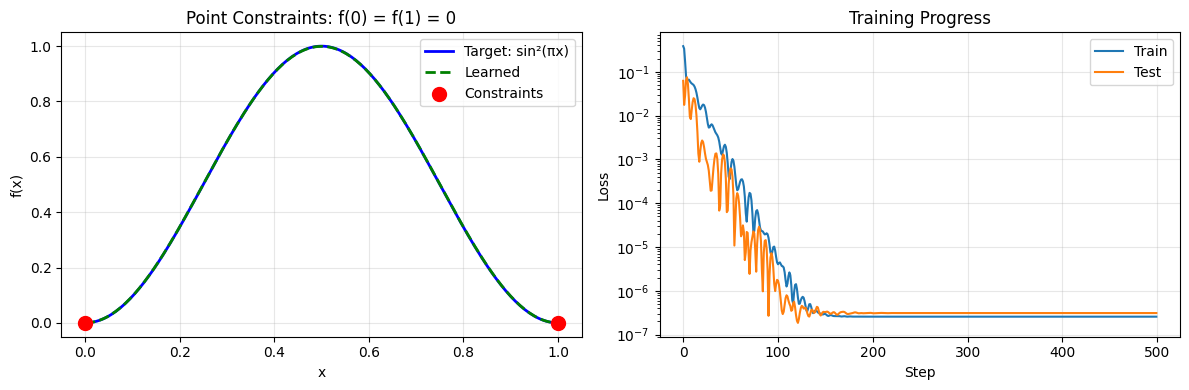

In [21]:
# Plot: Learned vs Target
x_plot = jnp.linspace(0, 1, 200).reshape(-1, 1)
y_learned, _ = model(x_plot, state)
y_target = target_fn(x_plot)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Function comparison
axes[0].plot(x_plot, y_target, 'b-', lw=2, label='Target: sin²(πx)')
axes[0].plot(x_plot, y_learned, 'g--', lw=2, label='Learned')
axes[0].scatter([0, 1], [0, 0], color='red', s=100, zorder=5, label='Constraints')
axes[0].set_xlabel('x')
axes[0].set_ylabel('f(x)')
axes[0].set_title('Point Constraints: f(0) = f(1) = 0')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: Training loss
axes[1].plot(results['train_loss'], label='Train')
axes[1].plot(results['test_loss'], label='Test')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training Progress')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

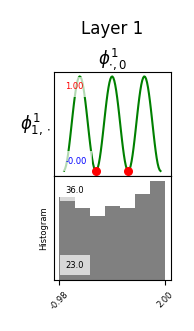

In [22]:
# Visualize the layer with constraint markers
plot_model(model, state)

## 2. Derivative Constraints

Now let's add derivative constraints to create a smooth bump function:
- `f(0) = 0, f(1) = 0` (boundary values)
- `f'(0) = 0, f'(1) = 0` (zero slope at boundaries)

In [24]:
# Define constraints with both position (d=0) and derivative (d=1)
constraints_in = [
    jnp.array([
        [0.0, 0],  # f(0) = 0 (value)
        [1.0, 0],  # f(1) = 0 (value)
        [0.0, 1],  # f'(0) = 0 (first derivative)
        [1.0, 1],  # f'(1) = 0 (first derivative)
    ])
]

constraints_y = [
    jnp.array([
        [0.0, 0.0, 0.0, 0.0],  # All constraints = 0
    ])
]

In [27]:
# Create model with derivative constraints
# Use higher degree k for derivative constraints
model_deriv, state_deriv = eqx.nn.make_with_state(AdaptKANJax)(
    width=[1, 1],
    num_grid_intervals=15,
    k=15,                              # Higher degree needed for derivative constraints
    basis_type='chebyshev',
    initialization_range=[0.0, 1.0],
    constraints_in=constraints_in,
    constraints_y=constraints_y,
    seed=42,
)

print(f"Layer 0 has_constraints: {model_deriv.layers[0].has_constraints}")

Layer 0 has_constraints: True


In [28]:
# Train with animations!
model_deriv, state_deriv, results_deriv = fit(
    model_deriv,
    state_deriv,
    train_data={"X": X_train, "y": y_train},
    test_data={"X": X_test, "y": y_test},
    loss_fn=mse_loss,
    opt="Adam",
    learning_rate=0.1,
    steps=500,
    log_freq=50,
    # Animation settings
    snapshot_every=10,                # Capture frame every 10 steps
    save_name="deriv_constraints",
    save_path="results/animations",
    fps=15,
)

print(f"\nAnimation saved to results/animations/deriv_constraints/")

 train_loss: 0.00000032 | test_loss: 0.00000010 |: 100%|█████████| 500/500 [00:02<00:00, 225.00it/s]


Saved GIF and 50 frames for Layer 1

Animation saved to results/animations/deriv_constraints/


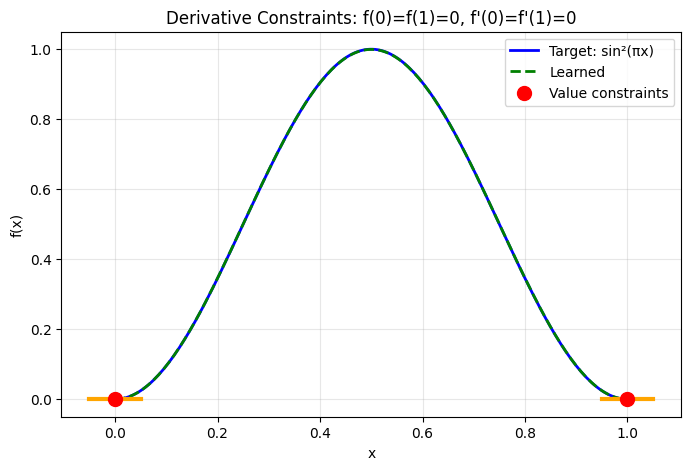

In [29]:
# Plot results with derivative constraints
y_learned_deriv, _ = model_deriv(x_plot, state_deriv)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x_plot, y_target, 'b-', lw=2, label='Target: sin²(πx)')
ax.plot(x_plot, y_learned_deriv, 'g--', lw=2, label='Learned')

# Mark constraint points
ax.scatter([0, 1], [0, 0], color='red', s=100, zorder=5, marker='o', label='Value constraints')

# Mark derivative constraints with horizontal lines (slope=0)
for x_c in [0.0, 1.0]:
    ax.plot([x_c-0.05, x_c+0.05], [0, 0], 'orange', lw=3, zorder=4)

ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title('Derivative Constraints: f(0)=f(1)=0, f\'(0)=f\'(1)=0')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

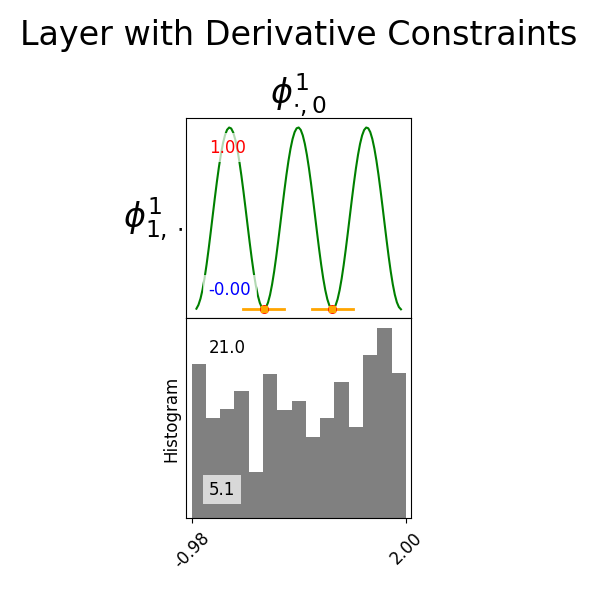

In [30]:
# Visualize layer with constraint markers
# Red dots = value constraints, Orange lines = derivative constraints
fig = plot_layer(model_deriv, state_deriv, layer_index=0, 
                 title="Layer with Derivative Constraints",
                 tangent_length=0.2,
                 square_size=2.5,
                 fontsize=12)
plt.show()

## 3. Constraints with Domain Adaptation

Constraints are maintained even when the domain expands. Let's train with data outside the initial domain.

In [59]:
# Generate training data OUTSIDE the initial [0, 1] domain
key = jax.random.PRNGKey(123)
X_train_ood = jax.random.uniform(key, (300, 1), minval=-0.5, maxval=1.5)
y_train_ood = target_fn(X_train_ood)

print(f"Training data range: [{float(X_train_ood.min()):.2f}, {float(X_train_ood.max()):.2f}]")
print("(This extends beyond initial domain [0, 1])")

Training data range: [-0.46, 1.50]
(This extends beyond initial domain [0, 1])


In [68]:
# Create model that will adapt its domain
model_adapt, state_adapt = eqx.nn.make_with_state(AdaptKANJax)(
    width=[1, 1],
    num_grid_intervals=9,
    k=15,
    basis_type='chebyshev',
    initialization_range=[0.0, 1.0],
    constraints_in=constraints_in,     # Same derivative constraints
    constraints_y=constraints_y,
    stretch_threshold=0.05,            # Expand if >5% data is out-of-domain
    prune_patience=3,
    seed=42,
)

layer = model_adapt.layers[0]
a_init = float(state_adapt.get(layer.a)[0])
b_init = float(state_adapt.get(layer.b)[0])
print(f"Initial domain: [{a_init:.2f}, {b_init:.2f}]")

Initial domain: [0.00, 1.00]


In [69]:
# Train with domain adaptation
model_adapt, state_adapt, results_adapt = fit(
    model_adapt,
    state_adapt,
    train_data={"X": X_train_ood, "y": y_train_ood},
    loss_fn=mse_loss,
    opt="Adam",
    learning_rate=0.1,
    steps=100,
    log_freq=5,
    adapt_model=True,                  # Enable domain adaptation
    # Animation settings
    snapshot_every=5,
    save_name="adapt_constraints",
    save_path="results/animations",
    fps=5,
)

# Check final domain
layer = model_adapt.layers[0]
a_final = float(state_adapt.get(layer.a)[0])
b_final = float(state_adapt.get(layer.b)[0])
print(f"\nFinal domain: [{a_final:.2f}, {b_final:.2f}]")
print(f"Domain adapted: {(a_final, b_final) != (a_init, b_init)}")
print(f"Adaptation events: {results_adapt['adapted_epochs']}")

 train_loss: 0.00000663 |: 100%|██████████████████████████████████| 100/100 [00:01<00:00, 91.63it/s]


Saved GIF and 20 frames for Layer 1

Final domain: [-0.46, 1.50]
Domain adapted: True
Adaptation events: [0]


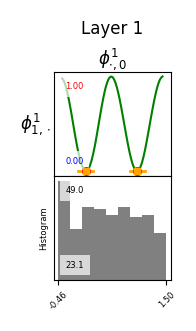

In [62]:
plot_model(model_adapt, state_adapt)

In [34]:
# IMPORTANT: Verify constraints are STILL satisfied after domain adaptation!
x_test_constraints = jnp.array([[0.0], [1.0]])
y_pred, _ = model_adapt(x_test_constraints, state_adapt)

print("Constraints after domain adaptation:")
print(f"  f(0) = {float(y_pred[0, 0]):.6f} (target: 0)")
print(f"  f(1) = {float(y_pred[1, 0]):.6f} (target: 0)")

Constraints after domain adaptation:
  f(0) = -0.000001 (target: 0)
  f(1) = 0.000000 (target: 0)


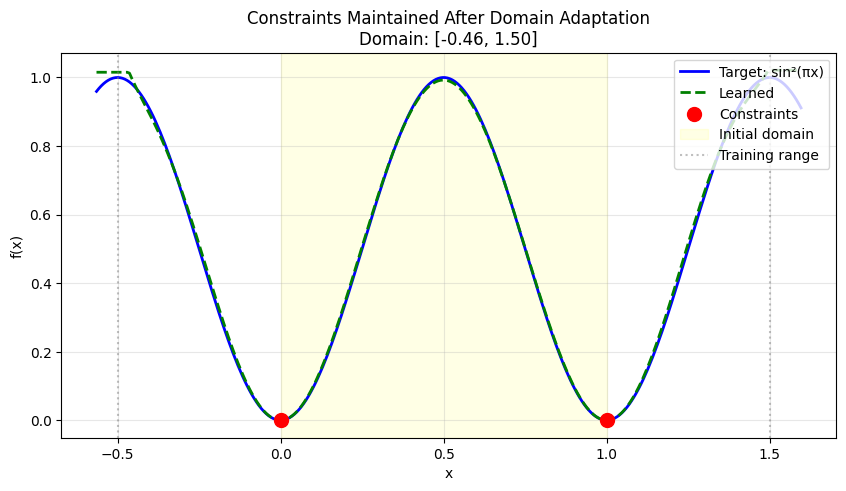

In [35]:
# Plot with expanded domain
x_plot_wide = jnp.linspace(a_final - 0.1, b_final + 0.1, 300).reshape(-1, 1)
y_learned_adapt, _ = model_adapt(x_plot_wide, state_adapt)
y_target_wide = target_fn(x_plot_wide)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_plot_wide, y_target_wide, 'b-', lw=2, label='Target: sin²(πx)')
ax.plot(x_plot_wide, y_learned_adapt, 'g--', lw=2, label='Learned')

# Mark constraint points
ax.scatter([0, 1], [0, 0], color='red', s=100, zorder=5, label='Constraints')

# Mark original domain
ax.axvspan(0, 1, alpha=0.1, color='yellow', label='Initial domain')

# Mark training data range  
ax.axvline(x=-0.5, color='gray', linestyle=':', alpha=0.5, label='Training range')
ax.axvline(x=1.5, color='gray', linestyle=':', alpha=0.5)

ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title(f'Constraints Maintained After Domain Adaptation\nDomain: [{a_final:.2f}, {b_final:.2f}]')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.show()

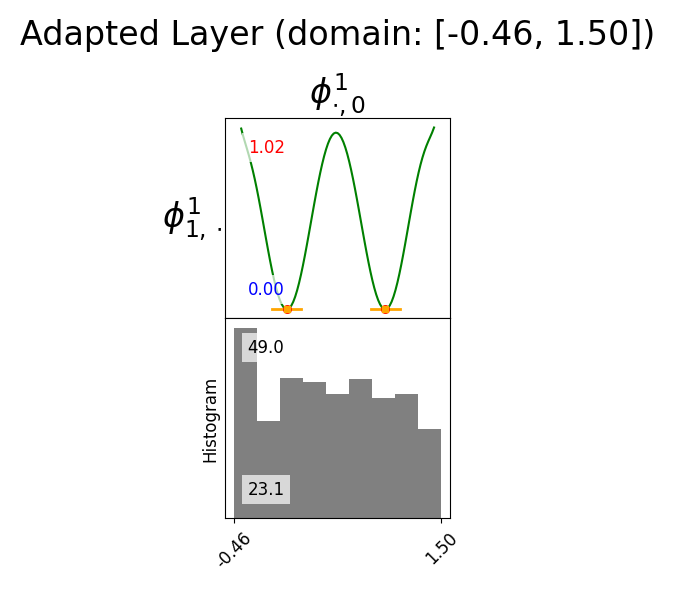

In [36]:
# Visualize the adapted layer
fig = plot_layer(model_adapt, state_adapt, layer_index=0,
                 title=f"Adapted Layer (domain: [{a_final:.2f}, {b_final:.2f}])",
                 tangent_length=0.15,
                 square_size=2.5,
                 fontsize=12)
plt.show()

## 4. Multi-Layer Networks with Constraints

You can apply constraints to specific layers in a deeper network. Use `None` for layers without constraints.

In [44]:
# TODO

## Summary

### Constraint Format
```python
# constraints_in: list of arrays per layer
# Each array: (n_constraints, 2) where columns are [x, derivative_order]
#   derivative_order: 0=value, 1=first derivative, 2=second derivative, etc.

# constraints_y: list of arrays per layer  
# Each array: (out_dim, n_constraints) with target values
# Use None for layers without constraints
```

### Key Points
1. Constraints require `basis_type='chebyshev'`
2. Use higher polynomial degree `k` for derivative constraints
3. Constraints are satisfied **exactly** throughout training
4. Constraints are maintained during domain adaptation
5. Use `snapshot_every` in `fit()` to create training animations